# EY Data Challenge - Sentinel-2 Notebook
For EY Data Challenge, I leveraged the "EY Data Challenge - Sentinel-2 Sample Notebook" as a starting point. This notebook demonstrates how to generate a Sentinel-2 satellite output product, either for a specific date or as a median mosaic over a selected time period. The median mosaic approach calculates the median pixel value for each spectral band across the time series, which helps statistically reduce cloud cover—assuming there are enough clear pixels available. The final output is a GeoTIFF file suitable for further analysis and for creating spectral index products like NDVI through mathematical combinations of bands. The notebook utilizes Sentinel-2 Level-2A data available from the MS Planetary Computer catalog at [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a).

In [1]:
# Loading required libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn, jet, RdBu
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates.

In [2]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)


In [3]:
# Calculate the bounds for doing an archive data search
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])



In [4]:
# Defining the time window
time_window = "2021-06-01/2021-09-01"

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a period of 3 months as a representative dataset for the region. The query searches for "low cloud" scenes with overall cloud cover <30%. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [5]:
# Search Sentinel-2 data with <30% cloud cover
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)



In [6]:
items = list(search.get_items())
print("Number of Sentinel-2 scenes available:", len(items))



Number of Sentinel-2 scenes available: 10


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, SWIR). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters.

In [7]:
# Sign the STAC items
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [8]:
# Define spatial resolution
resolution = 10  # meters per pixel
scale = resolution / 111320.0  # degrees per pixel

### Sentinel-2 Bands Summary
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m

In [9]:
# Load Sentinel-2 bands
data = stac_load(
    items,
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "AOT", "B09", "WVP", "SCL"],
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [10]:

# Display dataset details
display(data)

<xarray.Dataset> Size: 678MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 10)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
Data variables: (12/14)
    B02          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    ...           ...
    B11          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    AOT          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B09          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    WVP          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    SCL          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds. You may want to use a scene from a single date, or create a median mosaic using all of the data in the time series. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above.

In [13]:
import os
os.environ["PROJ_LIB"] = r"C:\Users\i\anaconda3\envs\EY2025data\Library\share\proj"

# Verify if the correct PROJ path is now used
import pyproj
print(pyproj.datadir.get_data_dir())


C:\Users\i\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\proj_dir\share\proj


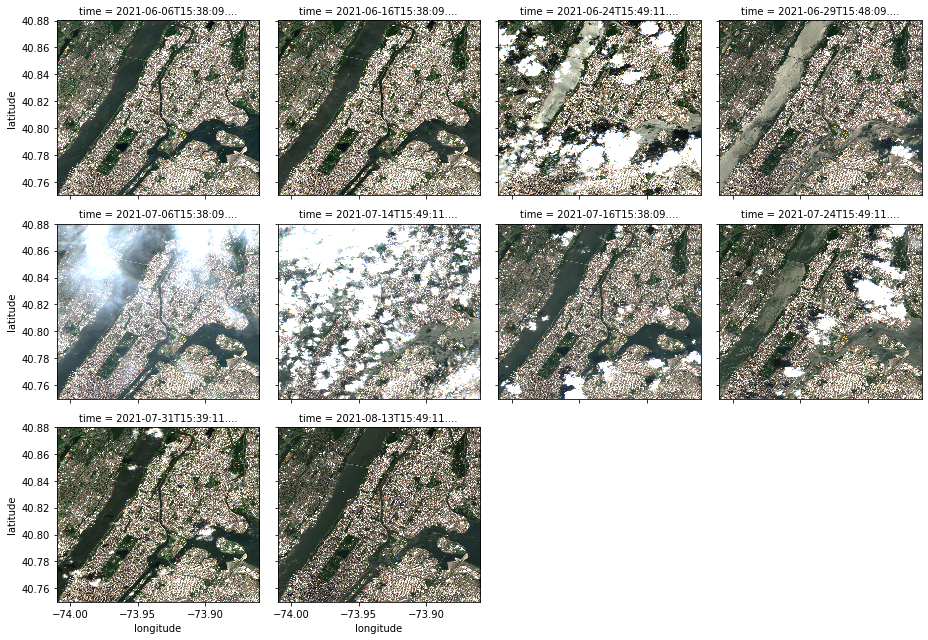

In [14]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

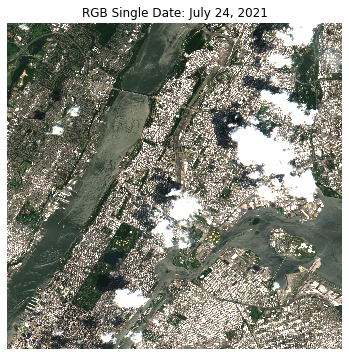

In [15]:
# Plot an RGB image for a single date
fig, ax = plt.subplots(figsize=(6,6))
plot_data.isel(time=7).plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Single Date: July 24, 2021")
ax.axis('off')
plt.show()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are not common (<30% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.

In [16]:
# Compute median composite to reduce cloud cover
median = data.median(dim="time").compute()

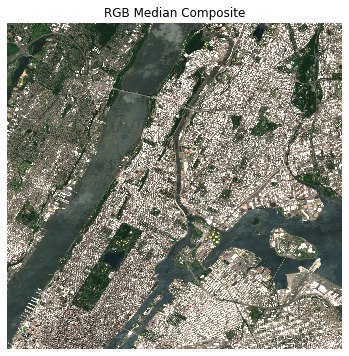

In [17]:

# Plot RGB image (True Color Composite)
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [18]:
# NDVI (Vegetation Index)
ndvi_median = (median.B08 - median.B04) / (median.B08 + median.B04)

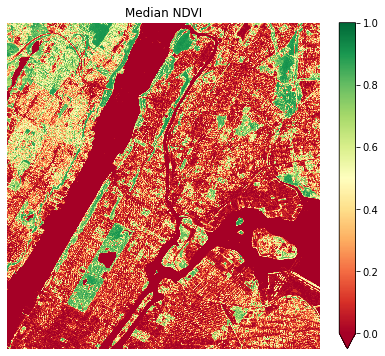

In [19]:

fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Buildup Index (NDBI)</b> is a ratio-based index that uses the Near Infra-red (NIR) and shortwave-infrared (SWIR) band (1.6 um, Band-11) to highlight built-up areas or areas of urbanization. Low values (below zero) reflect a lack of urbanization and are typical of water or vegetgation. High values (above zero) reflect urbanization with the highest densities where the colors are dark red. Such information can be relevant to modeling urban heating as urban density and increase urban heating. The equation uses two spectral bands where: <b>NDBI = (SWIR-NIR) / (SWIR+NIR).

In [20]:

# NDBI (Built-up Index)
ndbi_median = (median.B11 - median.B08) / (median.B11 + median.B08)

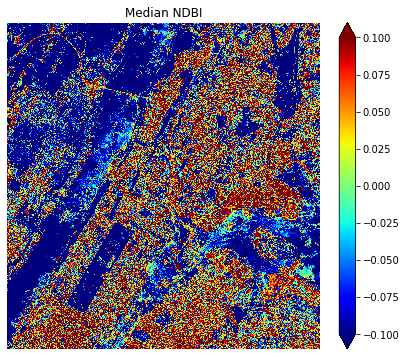

In [21]:
fig, ax = plt.subplots(figsize=(7,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()


The <b>Normalized Difference Water Index (NDWI)</b> is a ratio-based index that uses the Green and Near Infra-Red (NIR) band to highlight areas with surface water. The scale below is set up to highlight areas of water (above zero) in BLUE and areas of non-water (below zero) in RED. Such information can be relevant to modeling urban heating as the proximity to water can mitigate urban heating. The equation uses two spectral bands where: <b>NDWI = (GREEN-NIR) / (GREEN+NIR).

In [22]:
# NDWI (Water Index)
ndwi_median = (median.B03 - median.B08) / (median.B03 + median.B08)

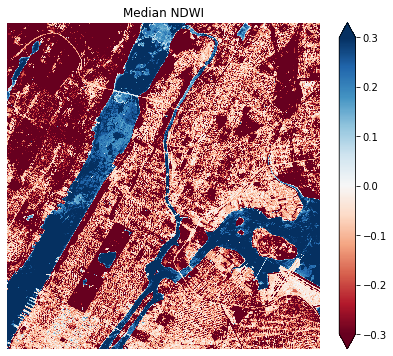

In [23]:
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()


### Save the output data in a GeoTIFF file
We have selected a single date (July 24, 2021) to create a GeoTIFF output product. This date is the same as the ground temperature data collection date.

In [24]:
# Save as GeoTIFF
filename = "Sentinel2.tiff"

In [25]:
data_slice = data.isel(time=7)  # Select a single time slice (July 24, 2021)

In [26]:
# Calculate the dimensions of the file
# height = median.dims["latitude"]
# width = median.dims["longitude"]
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]


In [27]:
# Define transform and CRS
gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True)



<xarray.Dataset> Size: 68MB
Dimensions:      (latitude: 1448, longitude: 1671)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    time         datetime64[ns] 8B 2021-07-24T15:49:11.024000
    spatial_ref  int64 8B 0
Data variables: (12/14)
    B02          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B03          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B04          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B05          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B06          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B07          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    ...           ...
    B11          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B12          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    AOT          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B09          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    WVP          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    SCL          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>

In [28]:
# Create GeoTIFF with updated bands
with rasterio.open(filename, 'w', driver='GTiff',
                   width=width,height=height,
                   crs='epsg:4326', transform=gt, count=14, compress='lzw', dtype='float64') as dst:
    dst.write(data_slice.B02, 1)
    dst.write(data_slice.B03, 2)
    dst.write(data_slice.B04, 3)
    dst.write(data_slice.B05, 4)
    dst.write(data_slice.B06, 5)
    dst.write(data_slice.B07, 6)
    dst.write(data_slice.B08, 7)
    dst.write(data_slice.B8A, 8)
    dst.write(data_slice.B11, 9)
    dst.write(data_slice.B12, 10)
    dst.write(data_slice.AOT, 11)
    dst.write(data_slice.B09, 12)
    dst.write(data_slice.WVP, 13)
    dst.write(data_slice.SCL, 14)
    dst.close()

print("GeoTIFF saved:", filename)


GeoTIFF saved: Sentinel2.tiff
